In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:, i, :, :].mean()
            std[i] += inputs[:, i, :, :].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

In [4]:
#To determine if your system supports CUDA
print("==> Check devices..")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Current device: ",device)

#Also can print your current GPU id, and the number of GPUs you can use.
print("Our selected device: ", torch.cuda.current_device())
print(torch.cuda.device_count(), " GPUs is available")
#device = 'cpu'

==> Check devices..
Current device:  cuda
Our selected device:  0
1  GPUs is available


In [5]:
print('==> Preparing dataset..')

==> Preparing dataset..


In [6]:
"""1.1"""
img_size, linear_size, fc1_out, fc2_out = 64, 13, 256, 84
#img_size, linear_size, fc1_out = 128, 29, 256
#img_size, linear_size, fc1_out = 256, 61, 256
#img_size, linear_size, fc1_out, fc2_out = 384, 93, 1024, 1024
#img_size, linear_size, fc1_out = 512, 125, 256
#img_size, linear_size, fc1_out = 512, 125, 512
#img_size, linear_size, fc1_out = 1024, 253, 256

calculate_mean_std = False

if calculate_mean_std == True:
    #The transform function for train data
    transform_train = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomCrop(img_size, padding=4),
        transforms.ToTensor(),
    ])

    #The transform function for test data
    transform_test = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomCrop(img_size, padding=4),
        transforms.ToTensor(),
    ])

    #we will calculate mean and std
    
    trainset = torchvision.datasets.ImageFolder(root='./food/training', transform=transform_train)
    testset = torchvision.datasets.ImageFolder(root='./food/evaluation', transform=transform_test)
    
    train_mean, train_std = get_mean_and_std(trainset)
    print(train_mean, train_std)
    test_mean, test_std = get_mean_and_std(testset)
    print(test_mean, test_std)
else:
    train_mean, train_std = ([0.5551, 0.4478, 0.3366]), ([0.2337, 0.2414, 0.2386])
    test_mean, test_std = ([0.5607, 0.4518, 0.3425]), ([0.2333, 0.2415, 0.2385])
    

In [7]:
"""1.1+"""
#The transform function for train data
transform_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomCrop(img_size, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

#The transform function for test data
transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomCrop(img_size, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(test_mean, test_std)
])

In [8]:
"""1.2+"""
trainset = torchvision.datasets.ImageFolder(root='./food/training', transform=transform_train)
testset = torchvision.datasets.ImageFolder(root='./food/evaluation', transform=transform_test)

In [9]:
"""1.3"""

#Create DataLoader to draw samples from the dataset
#In this case, we define a DataLoader to random sample our dataset. 
#For single sampling, we take one batch of data. Each batch consists 4 images
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
shuffle=False, num_workers=2)

In [10]:
classes = ('Bread', 'DairyProduct', 'Dessert', 'Egg', 'Friedfood',
           'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable')

In [11]:
print('==> Building model..')

==> Building model..


In [12]:
import torch.nn as nn

In [13]:
# define your own model
class Net(nn.Module):

    #define the layers
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * linear_size * linear_size, fc1_out)
        self.fc2 = nn.Linear(fc1_out, fc2_out)
        self.fc3 = nn.Linear(fc2_out, 11)
        self.relu = nn.ReLU()
        
    #concatenate these layers
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * linear_size * linear_size)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
#declare a new model
net = Net()
# change all model tensor into cuda type
# something like weight & bias are the tensor 
#net = net.to(device)
print(device)
if device == 'cuda':
    net = net.cuda(0)
else:
    net = net.cpu()

cuda


########################################################################

# 3. Define a Loss function and optimize

########################################################################

In [15]:
print('==> Defining loss function and optimize..')

==> Defining loss function and optimize..


In [16]:
import torch.optim as optim

#loss function
criterion = nn.CrossEntropyLoss()
#optimization algorithm
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)

########################################################################

# 4. Train the network

Before training the model, we need to analysis the tensor variable.


Each variable have many attibute, like: .grad_fn, .require_grad, .data, .grad...etc. The ".grad_fn" attribute of "torch.Tensor" is an entry point into the function that has create this "torch.Tensor" variables. Because of ".grad_fn" flag, we can easily create a computing graph in the form of DAG(directed acyclic graph).

And then, the ".require_grad" attribute allows us to determine whether the backward propagation function is going to calculate the gradient of this "torch.Tensor" variable. If one variable has a false value of require_grad, it represent that you don't want to calculate this variable's gradient, and also its gradient will not be updated.

########################################################################

In [17]:
print('==> Training model..')

==> Training model..


In [18]:
#Set the model in training mode
#because some function like: dropout, batchnorm...etc, will have 
#different behaviors in training/evaluation mode
#[document]: https://pytorch.org/docs/stable/nn.html#torch.nn.Module.train
net.train()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.9)

for epoch in range(5):  # loop over the dataset multiple times
    #scheduler.step()
    running_loss = 0.0
    correct = 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        
        #change the type into cuda tensor 
        if device == 'cuda':
            inputs = inputs.cuda(0)
            labels = labels.cuda(0)
        else:
            inputs = inputs.cpu()
            labels = labels.cpu()

        #print(labels)
        #print(inputs)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        # select the class with highest probability
        _, pred = outputs.max(1)
        # if the model predicts the same results as the true
        # label, then the correct counter will plus 1
        correct += pred.eq(labels).sum().item()
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print(i, " ", end="")


        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
        
    print('%d epoch, training accuracy: %.4f' % (epoch+1, 100.*correct/len(trainset)))
print('Finished Training')

[1,   200] loss: 2.296
1 epoch, training accuracy: 16.5822
[2,   200] loss: 2.236
2 epoch, training accuracy: 18.3864
[3,   200] loss: 2.236
3 epoch, training accuracy: 18.4573
[4,   200] loss: 2.228
4 epoch, training accuracy: 18.5587
[5,   200] loss: 2.216
5 epoch, training accuracy: 19.5925
Finished Training


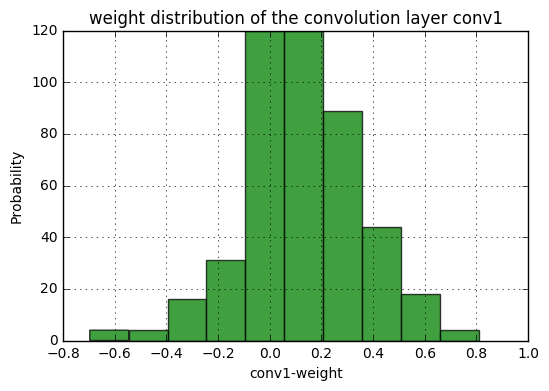

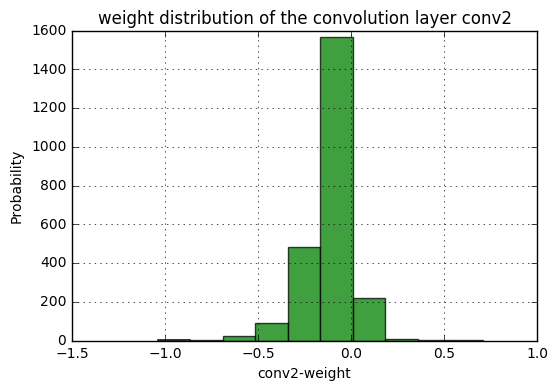

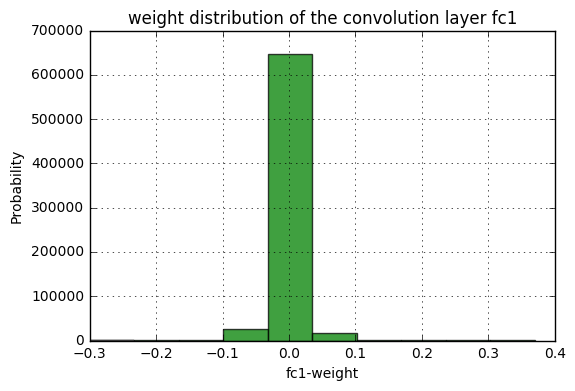

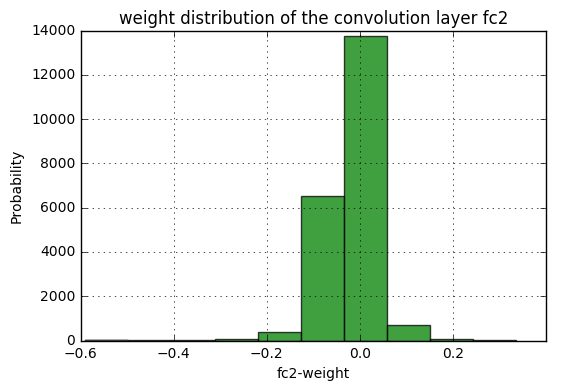

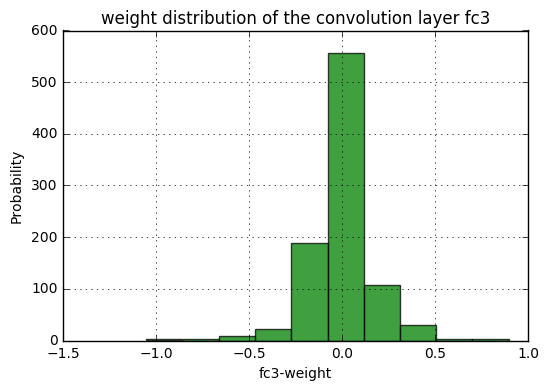

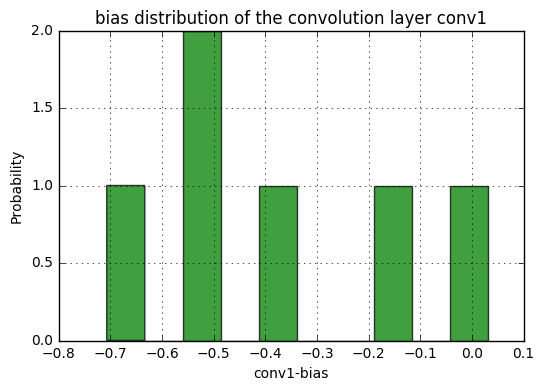

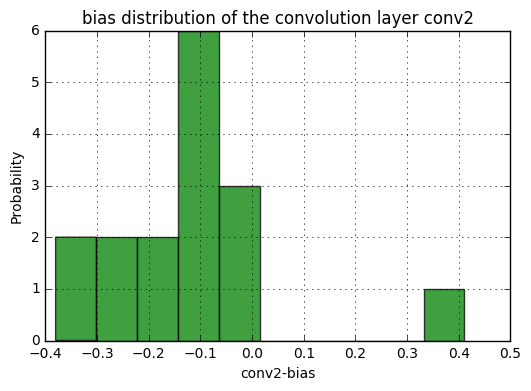

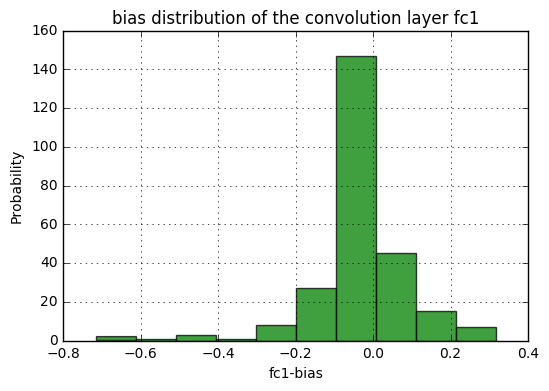

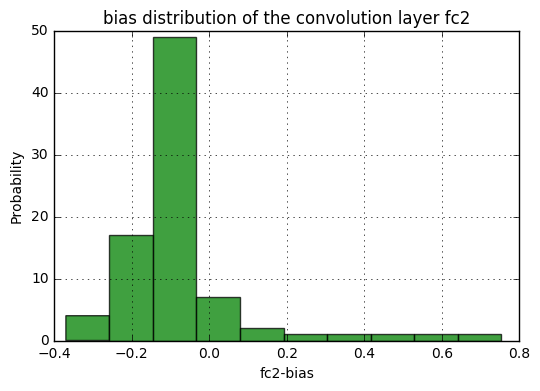

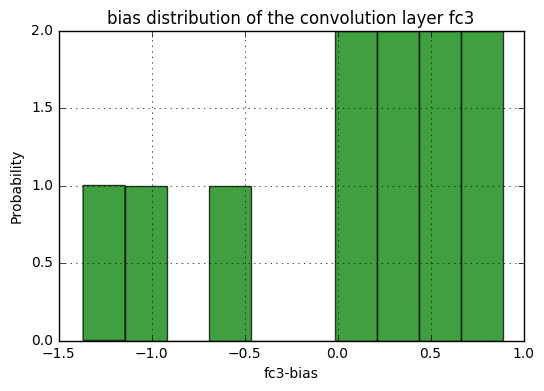

In [19]:
######################
#######LAB 1-1########
"""
To Do Here
        You should show the weight distribution of the convolution layer (conv1, conv2)
        You should show the bias distribution of the convolution layer (conv1, conv2)
        [hint] you can use matplotlib package to show the result in here
"""
######################
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

x = net.conv1.weight.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('conv1-weight')
plt.ylabel('Probability')
plt.title('weight distribution of the convolution layer conv1')

plt.grid(True)
plt.show()

x = net.conv2.weight.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('conv2-weight')
plt.ylabel('Probability')
plt.title('weight distribution of the convolution layer conv2')

plt.grid(True)
plt.show()

x = net.fc1.weight.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('fc1-weight')
plt.ylabel('Probability')
plt.title('weight distribution of the convolution layer fc1')

plt.grid(True)
plt.show()

x = net.fc2.weight.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('fc2-weight')
plt.ylabel('Probability')
plt.title('weight distribution of the convolution layer fc2')

plt.grid(True)
plt.show()

x = net.fc3.weight.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('fc3-weight')
plt.ylabel('Probability')
plt.title('weight distribution of the convolution layer fc3')

plt.grid(True)
plt.show()

x = net.conv1.bias.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('conv1-bias')
plt.ylabel('Probability')
plt.title('bias distribution of the convolution layer conv1')

plt.grid(True)
plt.show()

x = net.conv2.bias.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('conv2-bias')
plt.ylabel('Probability')
plt.title('bias distribution of the convolution layer conv2')

plt.grid(True)
plt.show()

x = net.fc1.bias.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('fc1-bias')
plt.ylabel('Probability')
plt.title('bias distribution of the convolution layer fc1')

plt.grid(True)
plt.show()

x = net.fc2.bias.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('fc2-bias')
plt.ylabel('Probability')
plt.title('bias distribution of the convolution layer fc2')

plt.grid(True)
plt.show()

x = net.fc3.bias.view(-1,1).cpu().detach().numpy()
n, bins, patches = plt.hist(x, facecolor='green', alpha=0.75)

plt.xlabel('fc3-bias')
plt.ylabel('Probability')
plt.title('bias distribution of the convolution layer fc3')

plt.grid(True)
plt.show()

In [20]:
#After training , save the model first
#You can saves only the model parameters or entire model
#Some difference between the two is that entire model 
#not only include parameters but also record hwo each 
#layer is connected(forward method).
#[document]: https://pytorch.org/docs/master/notes/serialization.html

print('==> Saving model..')

#only save model parameters
torch.save(net.state_dict(), './checkpoint.t7')
#you also can store some log information
state = {
    'net': net.state_dict(),
    'acc': 100.*correct/len(trainset),
    'epoch': 75
}
torch.save(state, './checkpoint.t7')

#save entire model
torch.save(net, './model.pt')

print('Finished Saving')

==> Saving model..
Finished Saving


/home/ccma/anaconda3/lib/python3.5/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


########################################################################

# 5. Test the network on the test data

########################################################################

#Before testing, we can load the saved model
#Depend on how you save your model, need 
#different way to use it

print('==> Loading model..')

#If you just save the model parameters, you
#need to redefine the model architecture, and
#load the parameters into your model
net = Net()
checkpoint = torch.load('./checkpoint.t7')
net.load_state_dict(checkpoint['net'])

#If you save the entire model
net = torch.load('./model.pt')

print('Finished Loading')

In [21]:
print('==> Testing model..')

#Set the model in evaluation mode
#[document]: https://pytorch.org/docs/stable/nn.html#torch.nn.Module.eval 
net.eval()


==> Testing model..


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=11, bias=True)
  (relu): ReLU()
)

In [22]:
######################
#######LAB 1-1########
"""
To Do Here

        You should complete the testing step in LAB 1-1
You should show the total accuracy & loss [10000 cifar10 test cases]
  You also need to tell us, how about the accuracy for each class
 
    For example: Total accuracy is: 60.0% and loss is: 0.02  
                 For each class in cifar 10:
                 Accuracy of plane : 58.0%
                 Accuracy of   car : 22.4%
                            .
                            .
                            .
"""
######################
correct = 0
total = 0

class_correct = list(0. for i in range(11))
class_total = list(0. for i in range(11))

with torch.no_grad():
    test_run = 0
    for data in testloader:
        images, labels = data

        if device == 'cuda':
            images = images.cuda(0)
            labels = labels.cuda(0)
        else:
            images = images.cpu()
            labels = labels.cpu()
        
        #print(test_run, " ", end="")
        #test_run = test_run + labels.size(0)
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        #print(predicted)
        #print(labels.size(0))
        #print("(", c, "), ")
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))

for i in range(11):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 3347 test images: 19 %
Accuracy of Bread :  0 %
Accuracy of DairyProduct :  0 %
Accuracy of Dessert : 50 %
Accuracy of   Egg :  0 %
Accuracy of Friedfood :  0 %
Accuracy of  Meat : 49 %
Accuracy of Noodles-Pasta :  0 %
Accuracy of  Rice :  0 %
Accuracy of Seafood :  0 %
Accuracy of  Soup : 34 %
Accuracy of Vegetable :  4 %
